In [1]:
"""" 
The current velocity of 2023's SD-1042 has a mean 37.4 degree angle from those on the nearby buoy 42022 in eastern GoM
or mean of 12 degree clockwise from buoy velocity to SD velocity
check bottom track test of SD-1042 to ensure the current velocity's data quality of SD-1042
"""
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import sys
import math
from numpy.linalg import norm
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)
from convert_dir import vector_dir_to_from

In [ ]:
### Info of SD-1042's merged adcp data
year = '2023'
platf_num = '1042'
path_cur_SD = '/Users/chi/Documents/projects/sd-ni-wp/data_manipulate/data_merge_adcp/'
tlim_plot = [datetime.datetime(int(year),10,24), datetime.datetime(int(year),10,25)] ### 2023 SD1042
tint = 3
nt_plot = int((tlim_plot[1]-tlim_plot[0]).days*24/tint)
tticks = [tlim_plot[0]+datetime.timedelta(hours=3*i) for i in range(nt_plot)]
tticks_label = [tticks[i].strftime('%m/%d %H') for i in range(len(tticks))]
print(tticks_label)
### load adcp data
ds_cur_SD = nc.Dataset(path_cur_SD+'adcp-raw-merge-'+year+'-SD'+platf_num+'.nc')
time = ds_cur_SD.variables['time'][:]
dtime_cur_SD = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=time[i]) for i in range(len(time))])
vars_str = ['longitude','latitude','bt_vel_east','bt_vel_north','vehicle_vel_east','vehicle_vel_north']
for i in range( len(vars_str) ):
    temp = ds_cur_SD.variables[vars_str[i]][:]
    temp.filled(np.nan)
    exec( vars_str[i]+' = temp')
del time

['10/24 00', '10/24 03', '10/24 06', '10/24 09', '10/24 12', '10/24 15', '10/24 18', '10/24 21']


In [44]:
### Read (From Mule) the navigation variables: SOG (speed over groud), COG (course over ground), ROLL (vechile heading, vechile yaw angle), 
# Roll (platform roll angle), Pitch (platform pitch angle)
str_vars = ['time','HDG','HDG_FILTERED_MEAN','ROLL_FILTERED_MEAN','PITCH_FILTERED_MEAN','SOG']
path = '/Volumes/disk3/projects/sdig-external/sdig/saildrone/hurricane_monitoring_'+year+'/delayed_post_mission/sd-'+platf_num+'/'
filenames_all = np.sort( os.listdir(path) )
filenames = np.array([])
for file in filenames_all: ### look for days of 10/24 - BT testing period
    if (year+'1024' in file) & ('.nc' in file):
        filenames = np.append(filenames, file)
# print(filenames)
### append variables
for i in range( len(filenames) ):
    ds_airsea = nc.Dataset(path+filenames[i])
    for str_var_i in str_vars:
        data_append = np.squeeze( ds_airsea.variables[str_var_i][:] )
        # print(filenames[i],str_var_i, data_append.size)
        if i == 0:
            str_exec = str_var_i+'= data_append'
        else:
            str_exec = str_var_i+'= np.append('+str_var_i+',data_append)'
        exec(str_exec)
    ds_airsea.close()
###
dtime_nav = np.array([datetime.datetime(1970,1,1)+datetime.timedelta(seconds=sec) for sec in time])

In [5]:
print(dtime_nav[0],dtime_nav[-1])

2023-10-24 00:00:00 2023-10-24 23:59:00


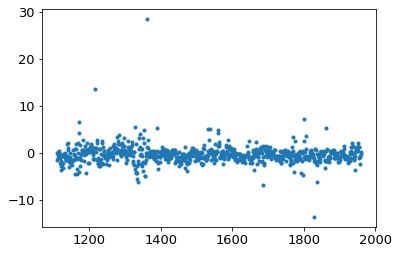

In [10]:
### compute the velocity direction
vehicle_vel_dir_to = np.nan*np.ones( dtime_cur_SD.shape )
bt_vel_dir_to = vehicle_vel_dir_to.copy()
for i in range( len(dtime_cur_SD) ):
    vehicle_vel_dir_to[i],_ = vector_dir_to_from(vehicle_vel_east[i], vehicle_vel_north[i])
    bt_vel_dir_to[i],_ = vector_dir_to_from(bt_vel_east[i], bt_vel_north[i])
### degrees between bt direction & opposite of vehicle direction to
# (positive degree from the opposite of vehicle headed direction to bt velocity headed direction)
deg_bt_to_negveh_clockwise = bt_vel_dir_to-((vehicle_vel_dir_to-180)%360)
deg_bt_to_negveh_clockwise[deg_bt_to_negveh_clockwise> 180] = deg_bt_to_negveh_clockwise[deg_bt_to_negveh_clockwise> 180]-360
deg_bt_to_negveh_clockwise[deg_bt_to_negveh_clockwise< -180] = deg_bt_to_negveh_clockwise[deg_bt_to_negveh_clockwise< -180]+360
plt.plot(deg_bt_to_negveh_clockwise,'.')

In [6]:
### compute cosine similarity between BT velocity and vehicle velocity
vector_bt = np.column_stack( (bt_vel_east, bt_vel_north) )
vector_veh = np.column_stack( (vehicle_vel_east, vehicle_vel_north) )
cosine_bt_veh = np.sum(vector_bt*vector_veh, axis=1)/(norm(vector_bt,axis=1)*norm(vector_veh,axis=1))
icos_out_of_range = np.where( np.abs(cosine_bt_veh)> 1)
if len(icos_out_of_range) < 0.01*len(vector_bt):
    deg_apart_btw_bt_veh = np.nan*np.ones(cosine_bt_veh.shape)
    cosine_bt_veh[icos_out_of_range] = np.round(cosine_bt_veh[icos_out_of_range])
    for i in range( len(cosine_bt_veh) ):
        deg_apart_btw_bt_veh[i] = math.degrees( math.acos(cosine_bt_veh[i]) ) # convert radians to degree
else:
    print('more than 1% of cosine is >1 or <-1. Check what before proceed.')

### compute arctan2 of the sum of BT & vehicle velocity
ycoord = bt_vel_north + vehicle_vel_north
xcoord = bt_vel_east + vehicle_vel_east
arctan2_bt_veh = np.arctan2(ycoord, xcoord)

/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_12679/2535678921.py:10: UserWarning: Warning: converting a masked element to nan.
  deg_apart_btw_bt_veh[i] = math.degrees( math.acos(cosine_bt_veh[i]) ) # convert radians to degree


<Figure size 432x288 with 0 Axes>

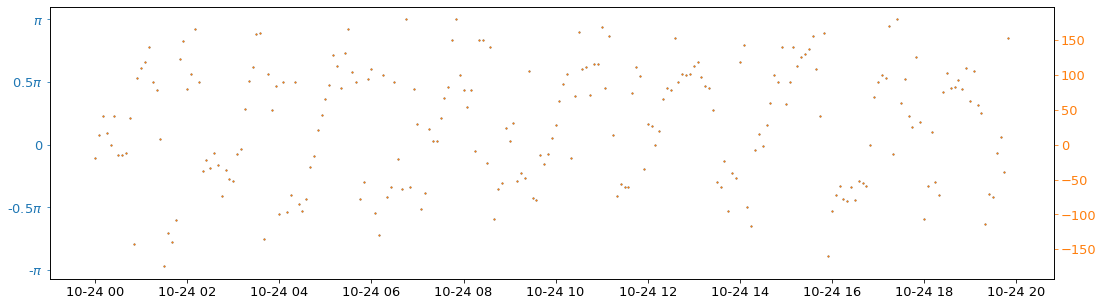

In [7]:
### plot arctan2 of the sum of vel_bt & vel_vehicle
it = np.where( (dtime_cur_SD>= tlim_plot[0]) & (dtime_cur_SD<= tlim_plot[1]))[0]
plt.clf()
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(1)
fig.set_size_inches(18, 5)
col = ['tab:blue','tab:orange']
ax0 = ax
ax1 = ax0.twinx()
### radians
ax0.plot(dtime_cur_SD[it], arctan2_bt_veh[it],'.',ms=2,color=col[0])
ax0.set_yticks(np.arange(-np.pi,1.5*np.pi,0.5*np.pi));
ax0.set_yticklabels(['-${\pi}$','-0.5${\pi}$','0','0.5${\pi}$','${\pi}$']);
### degrees
deg_vel_bt_veh = np.array([math.degrees(arctan2_bt_veh[i]) for i in range( len(dtime_cur_SD) )])
ax1.plot(dtime_cur_SD[it], deg_vel_bt_veh[it],'.',ms=2,color=col[1])
### color settings
for i in range( len(col) ):
    ax_str = 'ax'+str(i); col_i = 'col[i]'
    exec(ax_str+'.yaxis.label.set_color('+col_i+')')
    exec(ax_str+'.tick_params(axis="y",colors='+col_i+')')

(array([ 2.,  2.,  3.,  5.,  8., 17., 20., 10., 13., 13., 12., 11., 12.,
        12., 31., 24., 16.,  9., 12.,  7.]),
 array([-3.05093277, -2.7413065 , -2.43168022, -2.12205395, -1.81242768,
        -1.50280141, -1.19317514, -0.88354887, -0.5739226 , -0.26429633,
         0.04532994,  0.35495621,  0.66458249,  0.97420876,  1.28383503,
         1.5934613 ,  1.90308757,  2.21271384,  2.52234011,  2.83196638,
         3.14159265]),
 <BarContainer object of 20 artists>)

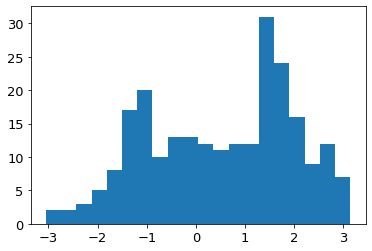

In [8]:
plt.hist(arctan2_bt_veh[it],20)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 432x288 with 0 Axes>

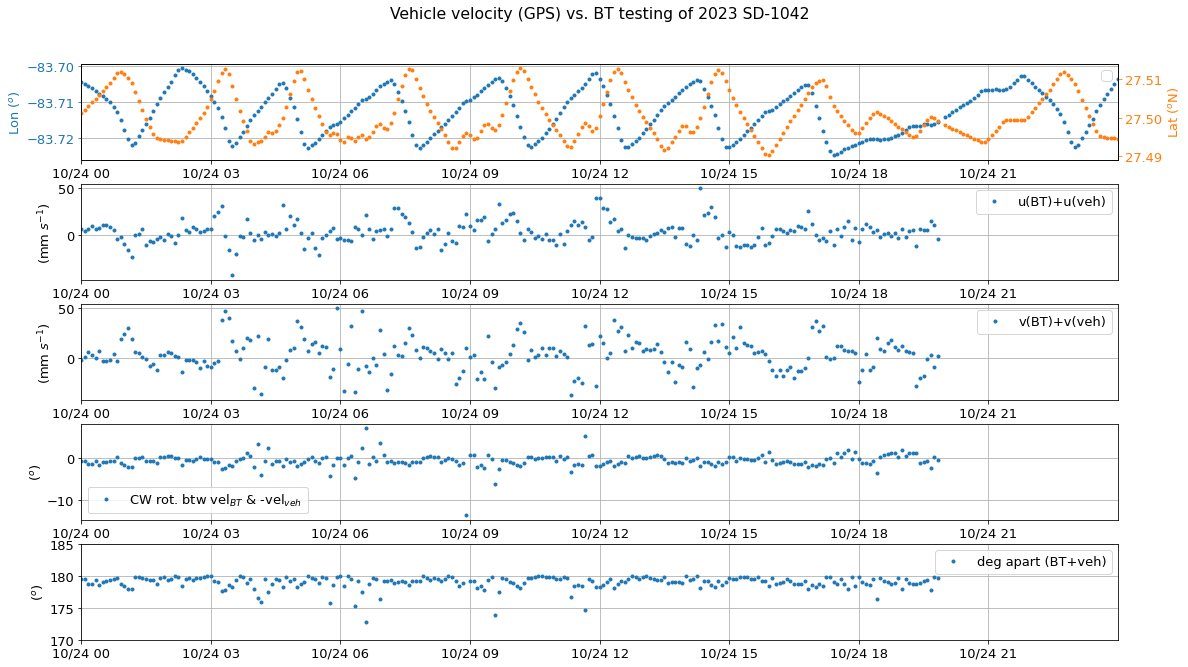

In [11]:
### plot bottom track velocity vs. vehicle velocity (determined by GPS -- assumed to be correct)
it = np.where( (dtime_cur_SD>= tlim_plot[0]) & (dtime_cur_SD<= tlim_plot[1]))[0]
nrow = 5
plt.clf()
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(nrow,1)
fig.set_size_inches(18, 10)
### lon/ lat
plt.subplot(nrow,1,1)
col = ['tab:blue','tab:orange']
ax0 = ax[0]
ax1 = ax0.twinx()
ax0.plot(dtime_cur_SD[it], longitude[it],'.',ms=6,color=col[0])
ax0.set_ylabel('Lon ($^o$)')
ax1.plot(dtime_cur_SD[it], latitude[it],'.',ms=6,color=col[1])
ax1.set_ylabel('Lat ($^o$N)')
### color settings
for i in range( len(col) ):
    ax_str = 'ax'+str(i); col_i = 'col[i]'
    exec(ax_str+'.yaxis.label.set_color('+col_i+')')
    exec(ax_str+'.tick_params(axis="y",colors='+col_i+')')
### u(BT)+u(veh)
plt.subplot(nrow,1,2)
du = (bt_vel_east+vehicle_vel_east)
plt.plot(dtime_cur_SD[it], du[it],'.',ms=6,label='u(BT)+u(veh)')
plt.legend(ncol=2,loc='best')
### arctan2 of vel(BT+veh)
dv = (bt_vel_north+vehicle_vel_north)
plt.subplot(nrow,1,3)
plt.plot(dtime_cur_SD[it], dv[it],'.',ms=6,label='v(BT)+v(veh)')
### degrees between bt direction & opposite of vehicle direction to (positive in )
plt.subplot(nrow,1,4)
plt.plot(dtime_cur_SD[it], deg_bt_to_negveh_clockwise[it],'.',ms=6,color=col[0],label='CW rot. btw vel$_{BT}$ & -vel$_{veh}$')
### cosine similarity
plt.subplot(nrow,1,5)
plt.plot(dtime_cur_SD[it], deg_apart_btw_bt_veh[it],'.',ms=6,label='deg apart (BT+veh)')
plt.ylim([170,185])
###
for i in range( nrow ):
    ax[i].set_xticks(tticks)
    ax[i].set_xticklabels(tticks_label)
    ax[i].set_xlim(tlim_plot)
    ax[i].grid()
    ax[i].legend(loc='best')
    if i == 1:
        ax[i].set_ylabel('(mm $s^{-1}$)')
    if i == 2:
        ax[i].set_ylabel('(mm $s^{-1}$)')
    if i == 3:
        ax[i].set_ylabel('($^o$)')
    if i == 4:
        ax[i].set_ylabel('($^o$)')

plt.suptitle('Vehicle velocity (GPS) vs. BT testing of '+year+' SD-'+platf_num)
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.25)
### save to figure
plt.savefig('timeseries_bt+veh_CW-rot-(bt&-veh)_cosine-similarity_'+year+'-SD'+platf_num+'_'+\
            tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'.png',dpi=400,bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

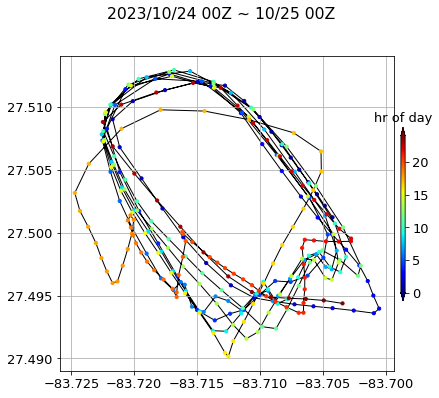

In [16]:
### plot SD location on map
# mday = np.array([(dtime_cur_SD[i]-datetime.datetime(int(year),10,1)).total_seconds()/86400+1 for i in range(len(dtime_cur_SD))])
# hour after tlim_plot[0]
hr_since_t0 = np.array([(dtime_cur_SD[i]-tlim_plot[0]).total_seconds()/3600 for i in range(len(dtime_cur_SD))])
plt.clf()
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(1,1)
fig.set_size_inches(6, 6)
# sc = plt.scatter( longitude[it], latitude[it], c=mday[it], s=1, vmin=mday[it][0], vmax=mday[it][-1], cmap='jet')
plt.plot(longitude[it], latitude[it],color='k',lw=1,zorder=1)
sc = plt.scatter( longitude[it], latitude[it], c=hr_since_t0[it], s=10, \
                 vmin=hr_since_t0[it][0], vmax=hr_since_t0[it][-1], cmap='jet',zorder=2)
ax.set_aspect('equal', adjustable='box')
plt.grid()
cbar_ax = fig.add_axes([.915,.3,.01,.4])
axf = plt.colorbar(sc,orientation='vertical',cax=cbar_ax,extend='both')
cbar_ax.set_title('hr of day',fontsize=13) # fraction day of the month
### save to figure
plt.suptitle(tlim_plot[0].strftime('%Y/%m/%d %HΖ ~ ')+tlim_plot[1].strftime('%m/%d %HΖ'))
plt.savefig('scatter_lon-lat_c=hrofday_'+year+'-SD'+platf_num+'_'+\
            tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'.png',dpi=400,bbox_inches='tight')

In [17]:
### compute the average, median, std, 10 & 90 percentile of the degree apart of BT+veh velocity
it = np.where( (dtime_cur_SD>= datetime.datetime(int(year),10,24)) & (dtime_cur_SD< datetime.datetime(int(year),10,25)) )[0]
y = deg_bt_to_negveh_clockwise[it]
perc = [5,95]
perc_y = np.percentile(y[~np.isnan(y)],perc)
print('=== stats of degree apart between BT velocity direction & opposite of vehicle velocity direction (positive clockwise) ===')
print( 'mean={:.2f}, median={:.2f}, std={:.2f}, \n{:.0f} & {:.0f} percentile = {:.2f}, {:.2f}'\
      .format(np.nanmean(y), np.nanmedian(y), np.nanstd(y), perc[0], perc[1], perc_y[0], perc_y[1]) )

=== stats of degree apart between BT velocity direction & opposite of vehicle velocity direction (positive clockwise) ===
mean=-0.51, median=-0.56, std=1.58, 
5 & 95 percentile = -2.13, 1.29


<Figure size 432x288 with 0 Axes>

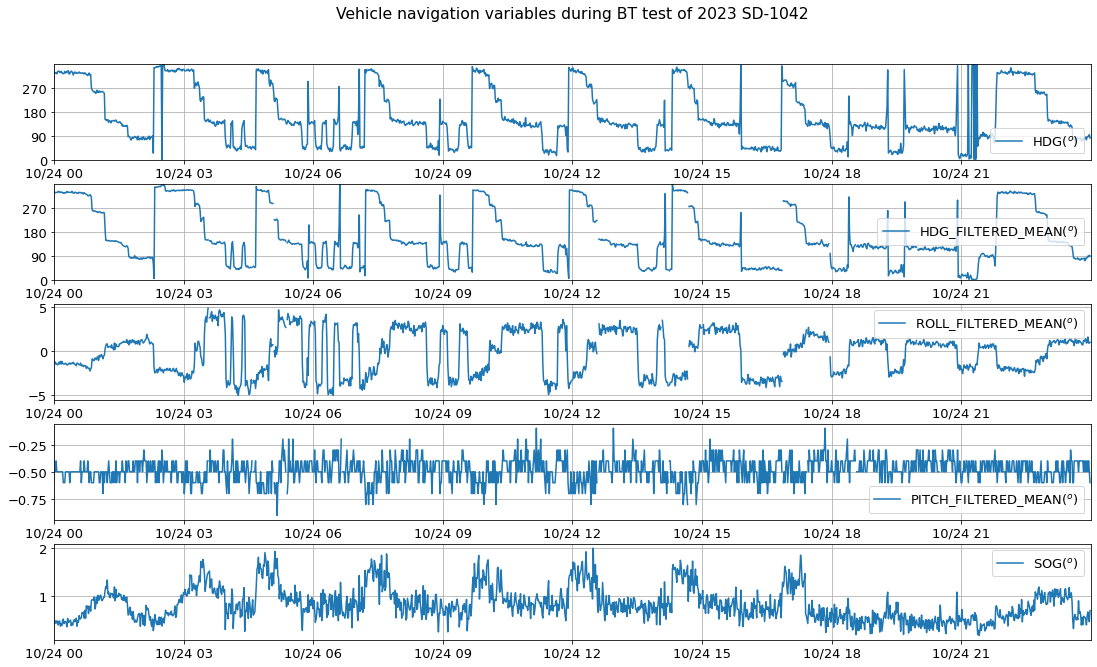

In [46]:
### plot nav variables
vars_plot = ['HDG','HDG_FILTERED_MEAN','ROLL_FILTERED_MEAN','PITCH_FILTERED_MEAN','SOG']
ylims_plot = [[0,360],[0,360],[],[],[]]
nrow = len(vars_plot)
plt.clf()
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(nrow,1)
fig.set_size_inches(18, 10)
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    plt.plot(dtime_nav, eval(vars_plot[i]),label=vars_plot[i]+'($^o$)')
    plt.xlim(tlim_plot)
    plt.grid()
    plt.legend(loc='best')
    plt.xticks(tticks)
    plt.gca().set_xticklabels(tticks_label)
    if len(ylims_plot[i]) > 0:
        plt.ylim(ylims_plot[i])
        plt.yticks(np.arange(ylims_plot[i][0],ylims_plot[i][1],90))

plt.suptitle('Vehicle navigation variables during BT test of '+year+' SD-'+platf_num)
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.25)
### save to figure
plt.savefig('timeseries_HDG_ROLL_PITCH_SOG_'+year+'-SD'+platf_num+'_'+\
            tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'.png',dpi=400,bbox_inches='tight')

0:02:30


<Figure size 432x288 with 0 Axes>

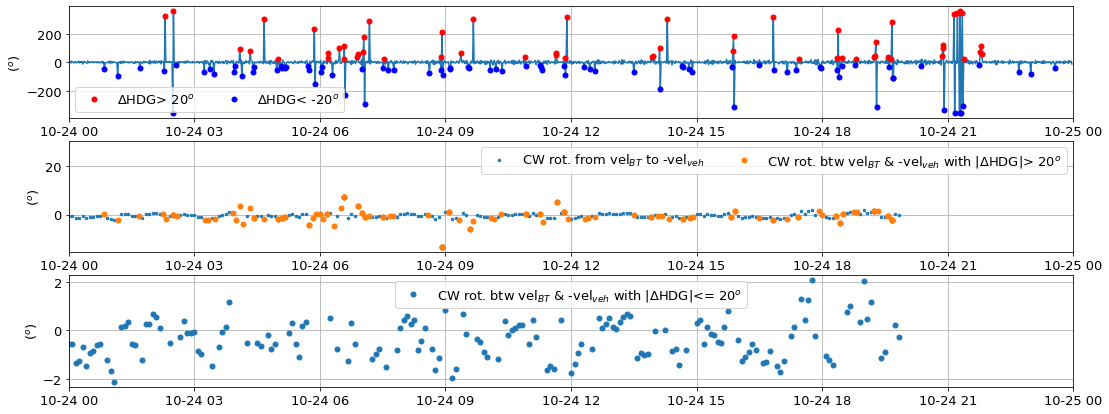

In [49]:
### plot timeseries of CW rotation from vel_BT to negative vel_vehicle, masking the times when vehicle heading is large
HDG_diff = np.diff( HDG )
HDG_crit = 20
dt_cur = datetime.timedelta(seconds=2.5*60); print(dt_cur)
###
nrow = 3
plt.clf()
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(nrow,1)
fig.set_size_inches(18, 7)
### (1) HDG vs HDG_diff > HDG_crit or < -HDG_crit (degrees)
plt.subplot(nrow,1,1)
# plt.hist( np.abs(HDG_diff),50)
plt.plot(dtime_nav[:-1], HDG_diff)
it_nav_large_HDG_diff = np.where( HDG_diff > HDG_crit )[0]
plt.plot(dtime_nav[:-1][it_nav_large_HDG_diff], HDG_diff[it_nav_large_HDG_diff],'o',ms=5,color='r',label='\u0394HDG> '+str(HDG_crit)+'$^o$')
it_nav_large_HDG_diff = np.where( HDG_diff < -HDG_crit )[0]
plt.plot(dtime_nav[:-1][it_nav_large_HDG_diff], HDG_diff[it_nav_large_HDG_diff],'o',ms=5,color='b',label='\u0394HDG< -'+str(HDG_crit)+'$^o$')
### (2) deg_bt_to_negveh_clockwise
plt.subplot(nrow,1,2)
plt.plot(dtime_cur_SD, deg_bt_to_negveh_clockwise,'.',ms=5,label='CW rot. from vel$_{BT}$ to -vel$_{veh}$')
it_nav_ok_HDG = np.where( np.abs(HDG_diff) <= HDG_crit )[0]
it_nav_notok_HDG = np.arange(0,len(dtime_nav))
it_nav_notok_HDG = np.delete(it_nav_notok_HDG, it_nav_ok_HDG)
### go through dtime_cur_SD and find the times of it_nav_ok_HDG
it_cur_notok_HDG = np.array([])
for i in it_nav_notok_HDG:
    temp = np.where( (dtime_cur_SD>= dtime_nav[i]-dt_cur) & (dtime_cur_SD<= dtime_nav[i]+dt_cur) )[0]
    if len(temp) > 0:
        it_cur_notok_HDG = np.append( it_cur_notok_HDG, temp[0] )
it_cur_notok_HDG = it_cur_notok_HDG.astype(int)
plt.plot(dtime_cur_SD[it_cur_notok_HDG], deg_bt_to_negveh_clockwise[it_cur_notok_HDG],'o',ms=5,label='CW rot. btw vel$_{BT}$ & -vel$_{veh}$ with |\u0394HDG|> '+str(HDG_crit)+'$^o$')

### (3) deg_bt_to_negveh_clockwise - remove |HDG_diff|> HDG_crit
plt.subplot(nrow,1,3)
it_cur_ok_HDG = np.arange(0,len(dtime_cur_SD))
it_cur_ok_HDG = np.delete(it_cur_ok_HDG, it_cur_notok_HDG)
it_cur_tlim = np.where( (dtime_cur_SD>= tlim_plot[0]) & (dtime_cur_SD<= tlim_plot[1] ))[0]
it_cur_ok_HDG = np.intersect1d(it_cur_ok_HDG, it_cur_tlim)
plt.plot(dtime_cur_SD[it_cur_ok_HDG], deg_bt_to_negveh_clockwise[it_cur_ok_HDG],'o',ms=5,label='CW rot. btw vel$_{BT}$ & -vel$_{veh}$ with |\u0394HDG|<= '+str(HDG_crit)+'$^o$')
### figure settings
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    plt.xlim(tlim_plot)
    plt.grid()
    plt.legend(loc='best',ncol=2)
    plt.ylabel('($^o$)')
### save to figure
plt.savefig('timeseries_HDG-diff(cri={:.0f}deg)_CW-rot-(bt&-veh)_'.format(HDG_crit)+year+'-SD'+platf_num+'_'+\
            tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'.png',dpi=400,bbox_inches='tight')

[datetime.datetime(2023, 10, 24, 0, 0), datetime.datetime(2023, 10, 25, 0, 0)]
limits prior to removing large ΔHDG: -13.585947617363018 7.188079176410838
limits after removing large ΔHDG: -2.1145884003332185 2.0840658259425595


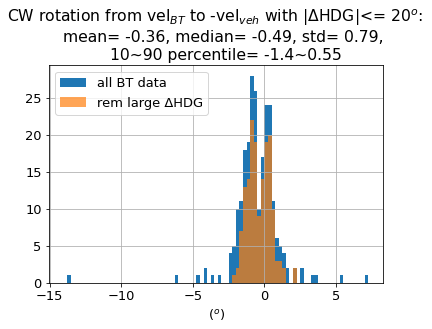

In [50]:
### plot the histogram of degree from vel_BT to vel_vehicle (positive in clockwise)
plt.clf()
### plot all data within the BT testing time limit
print(tlim_plot)
it = np.where( (dtime_cur_SD>= tlim_plot[0]) & (dtime_cur_SD<= tlim_plot[1]))[0]
y = deg_bt_to_negveh_clockwise[it]
print('limits prior to removing large \u0394HDG:',np.nanmin(y),np.nanmax(y))
plt.hist(y,bins=np.arange(-14,7.5,0.25), alpha=1, label='all BT data')
### plot data that has ok HDG changes with time
y = deg_bt_to_negveh_clockwise[it_cur_ok_HDG]
perc_num = [10,90]
isOK = ~np.isnan(y)
y = y[isOK]
perc_y = np.percentile(y, perc_num)
print('limits after removing large \u0394HDG:',np.nanmin(y), np.nanmax(y))
plt.hist(y,bins=np.arange(-14,7.5,0.25), alpha=0.7, label='rem large \u0394HDG')
### figure settings
plt.grid()
plt.legend(loc='best')
title = 'CW rotation from vel$_{BT}$ to -vel$_{veh}$ with |\u0394HDG|<= '+str(HDG_crit)+'$^o$: \n\
    mean= {:.2f}, median= {:.2f}, std= {:.2f}, \n\
    {:.0f}~{:.0f} percentile= {:.2}~{:.2f}'.\
    format(np.mean(y), np.median(y), np.std(y), perc_num[0], perc_num[1], perc_y[0], perc_y[1])
plt.title(title)
plt.xlabel('($^o$)')
### save to figure
plt.savefig('hist_CW-rot-(bt&-veh)_rem-HDG-diff(cri={:.0f}deg)_'.format(HDG_crit)+year+'-SD'+platf_num+'_'+\
            tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'.png',dpi=400,bbox_inches='tight')

Text(0, 0.5, 'CW rotation ($^o$)')

<Figure size 432x288 with 0 Axes>

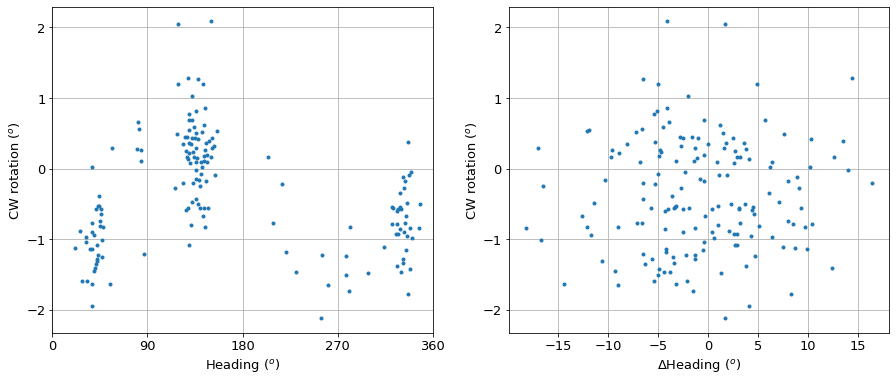

In [51]:
### Look at heading and heading changes vs. CW rotation (btw vel_BT & -vel_veh)
### only looking data with HDG changes< 10/ 15/ 20/ 30 degrees. 
dtime_check_HDG = dtime_cur_SD[it_cur_ok_HDG]
HDG_on_cur_ok_HDG = np.nan*np.ones( dtime_check_HDG.shape )
HDG_diff_on_cur_ok_HDG = HDG_on_cur_ok_HDG.copy()
dt_range = datetime.timedelta(seconds=30)

for i, dtime in enumerate( dtime_check_HDG ):
    it_nav = np.where( (dtime_nav>= dtime-dt_range) & (dtime_nav<= dtime+dt_range) )[0]
    HDG_on_cur_ok_HDG[i] = HDG[it_nav]
    HDG_diff_on_cur_ok_HDG[i] = HDG_diff[it_nav]

### plot 
ncol = 2
plt.clf()
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(1,ncol)
fig.set_size_inches(15, 6)
###
plt.subplot(1,ncol,1)
plt.plot(HDG_on_cur_ok_HDG, deg_bt_to_negveh_clockwise[it_cur_ok_HDG],'.')
plt.xlim([0,360])
plt.xticks(np.arange(0,450,90))
plt.grid()
plt.xlabel('Heading ($^o$)')
plt.ylabel('CW rotation ($^o$)')
###
plt.subplot(1,ncol,2)
plt.plot(HDG_diff_on_cur_ok_HDG, deg_bt_to_negveh_clockwise[it_cur_ok_HDG],'.')
plt.grid()
plt.xlabel('\u0394Heading ($^o$)')
plt.ylabel('CW rotation ($^o$)')


<Figure size 432x288 with 0 Axes>

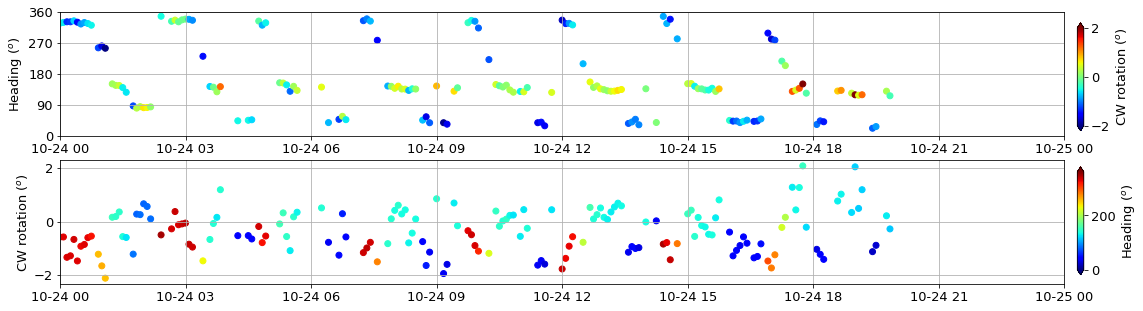

In [53]:
### plot time series colored by HDG or CW rotation
nrow = 2
plt.clf()
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(nrow,1)
fig.set_size_inches(18, 5)
###
plt.subplot(nrow,1,1)
sc = plt.scatter(dtime_check_HDG, HDG_on_cur_ok_HDG, c=deg_bt_to_negveh_clockwise[it_cur_ok_HDG],cmap='jet',vmin=-2,vmax=2)
plt.xlim(tlim_plot)
plt.ylim([0,360])
plt.yticks(np.arange(0,450,90))
plt.ylabel('Heading ($^o$)')
plt.grid()
### add colorbar
cbar_ax = fig.add_axes([.91,0.55,.005,0.3])
axf = plt.colorbar(sc,orientation='vertical',cax=cbar_ax,extend='both')
axf.set_label('CW rotation ($^o$)')
### 
plt.subplot(nrow,1,2)
sc = plt.scatter(dtime_check_HDG, deg_bt_to_negveh_clockwise[it_cur_ok_HDG], c=HDG_on_cur_ok_HDG,cmap='jet',vmin=0,vmax=360)
plt.xlim(tlim_plot)
plt.ylabel('CW rotation ($^o$)')
plt.grid()
### add colorbar
cbar_ax = fig.add_axes([.91,0.15,.005,0.3])
axf = plt.colorbar(sc,orientation='vertical',cax=cbar_ax,extend='both')
axf.set_label('Heading ($^o$)')
###
### save to figure
plt.savefig('scatter_HDG(HDG-diff-cri={:.0f}deg)_CW-rot-(bt&-veh)_'.format(HDG_crit)+year+'-SD'+platf_num+'_'+\
            tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'.png',dpi=400,bbox_inches='tight')